In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import itertools

def corner_scatter_color(
    fname="A_phys_table_4D.csv",
    param_cols=None,                 # 参与作图的超参列；None 时自动从文件推断
    value_col="A_phys",              # 颜色对应的列
    fixed_filters=None,              # 例如 {'xi_DM': 0.0}；会先按此筛选
    agg="mean",                      # 多维投影在两维上聚合：'mean'/'max'/'median'
    log_color=True,                  # 颜色是否取对数
    s=1,                             # 散点大小
    figsize=(9,9),
    cmap="viridis",
    clip_percentile=(1, 99),         # 颜色上下限百分位裁剪，减少极端值影响
    subsample=None                   # 如 100000 表示最多采 10 万个点
):
    df = pd.read_csv(fname)

    # 自动识别参数列
    if param_cols is None:
        candidates = [c for c in ["mu_DM","sigma_DM","beta_DM","xi_DM"] if c in df.columns]
        if not candidates:
            raise ValueError("未找到参数列（期望包含 mu_DM/sigma_DM/beta_DM/xi_DM 中的若干列）")
        param_cols = candidates

    # 固定某些维度（如 xi_DM = 0）
    if fixed_filters:
        for k, v in fixed_filters.items():
            if k in df.columns:
                df = df[np.isclose(df[k], v)]

    # 需要画的维度
    cols = [c for c in param_cols if c in df.columns]
    if len(cols) < 2:
        raise ValueError("至少需要两维参数来画 corner 图")

    # 颜色裁剪范围
    v = df[value_col].to_numpy()
    vmin, vmax = np.percentile(v[~np.isnan(v)], clip_percentile)
    norm = LogNorm(vmin=max(vmin, 1e-12), vmax=vmax) if log_color else Normalize(vmin=vmin, vmax=vmax)

    # 子采样（防止点数过多）
    if subsample is not None and len(df) > subsample:
        df = df.sample(subsample, random_state=0)

    # 聚合函数
    agg_func = {"mean": np.mean, "max": np.max, "median": np.median}[agg]

    # 画布
    n = len(cols)
    fig, axes = plt.subplots(n, n, figsize=figsize, squeeze=False)
    plt.subplots_adjust(wspace=0.08, hspace=0.08)

    # 遍历子图
    for i, yi in enumerate(cols):
        for j, xj in enumerate(cols):
            ax = axes[i, j]

            if i == j:
                # 对角：在该维的不同取值处，对其他维聚合，画一条“颜色加权”的散点/线
                # 做法：按该维分组，取 value 的聚合，然后散点连线
                grp = df.groupby(yi, as_index=False)[value_col].agg(agg)
                ax.plot(grp[yi], grp[value_col], lw=0.5)
                ax.set_ylabel(value_col if j == 0 else "")
                ax.set_xlabel(yi)
                ax.grid(True, ls='--', alpha=0.3)
            elif i > j:
                # 下三角：二维投影散点，其他维聚合
                others = [c for c in cols if c not in [xj, yi]]
                if others:
                    # 在 (xj, yi) 的唯一组合上聚合其他维度
                    grp = df.groupby([xj, yi], as_index=False)[value_col].agg(agg)
                    X = grp[xj].to_numpy()
                    Y = grp[yi].to_numpy()
                    C = grp[value_col].to_numpy()
                else:
                    X = df[xj].to_numpy()
                    Y = df[yi].to_numpy()
                    C = df[value_col].to_numpy()

                sc = ax.scatter(X, Y, c=C, s=s, cmap=cmap, norm=norm)
                ax.set_xlabel(xj if i == n-1 else "")
                ax.set_ylabel(yi if j == 0 else "")
                ax.grid(True, ls='--', alpha=0.2)
            else:
                # 上三角留白或镜像
                ax.axis("off")

    # 统一加一个颜色条
    cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label(value_col + (" (log)" if log_color else ""))

    fig.suptitle("Corner plot colored by A_eta, subsample={}".format(subsample) if subsample else "Corner plot colored by A_eta", fontsize=16)
    plt.show()




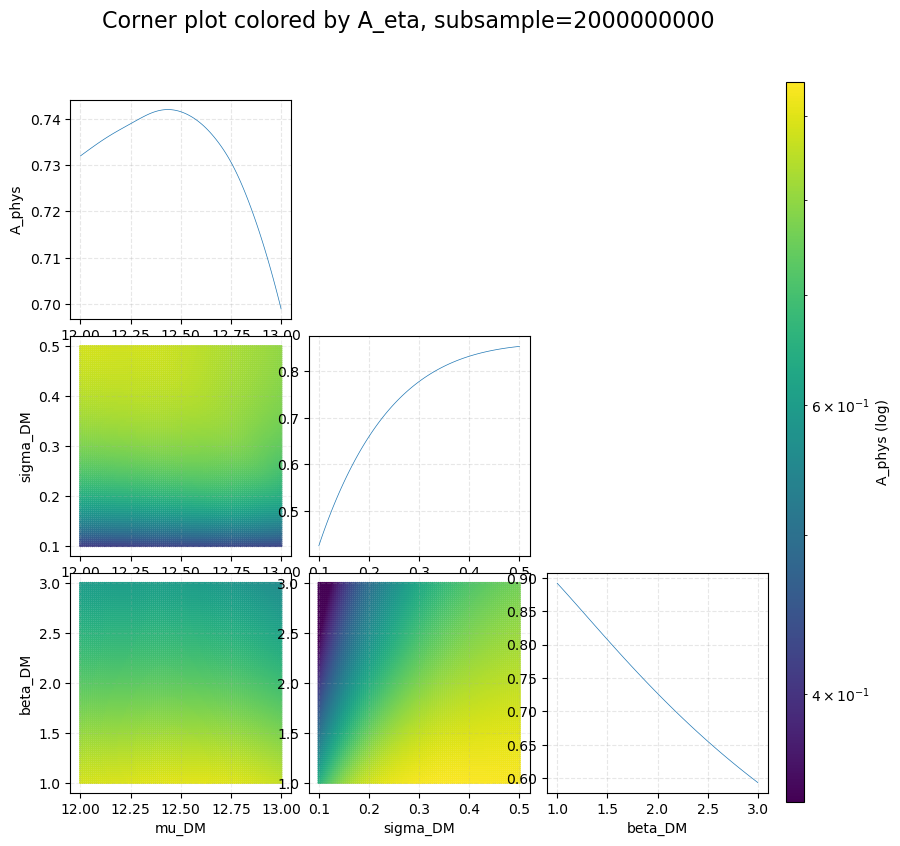

In [15]:
# ======= 用法示例 =======
# 1) xi_DM 固定为 0 的情况（你的当前设置）
corner_scatter_color("../tables/A_phys_table_4D_new.csv",
                     param_cols=["mu_DM","sigma_DM","beta_DM"],  # 三维
                     fixed_filters=None,
                     agg="mean", log_color=True, subsample=2000000000)

# # 2) 若 xi_DM 也在网格里，可一并画四维的 pairwise 投影
# corner_scatter_color("A_phys_table_4D.csv",
#                      param_cols=["mu_DM","sigma_DM","beta_DM","xi_DM"],
                    #  fixed_filters=None, agg="mean", log_color=True)
